# **Movie Review Sentiment**

---



---





---



---

![alt text](http://katalystcommunications.com/wp-content/uploads/2016/02/brand-sentiment2-880x470.jpg)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
pip install emoji

In [0]:
#Importing libraries
import numpy as np
from emoji_util import *
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

%matplotlib inline

## Load Dataset

---



---



---



In [4]:
#Load dataset
data=pd.read_csv('/content/drive/My Drive/movie review/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


## Preprocess Data

---



---






In [0]:
#Preprocessing data
import re
tag_re =re.compile(r'<[^>]+>')
def remove_tags(text):
  return tag_re.sub(' ',text)
def preprocess_text(sent):
  sentence=remove_tags(sent)
  sentence=re.sub('[^a-zA-Z]',' ',sentence)
  sentence=re.sub('\s+[a-zA-z]\s+',' ',sentence)
  sentence=re.sub('\s+',' ',sentence)
  return sentence


In [7]:
from tqdm import tqdm
X=[]
sentences=list(data['review'])
for sent in tqdm(sentences):
  X.append(preprocess_text(sent))


100%|██████████| 50000/50000 [00:07<00:00, 6604.19it/s]


In [8]:
X=np.array(X)
X[0]

'One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty picture

In [9]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
encoder=LabelEncoder()
one_encoder=OneHotEncoder(sparse=False)
Y=encoder.fit_transform(data['sentiment'])
Y

array([1, 1, 1, ..., 0, 0, 0])

In [0]:
#Splitting dataset in train and test set
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2, random_state=42)

In [11]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((40000,), (40000,), (10000,), (10000,))

In [0]:
maxlen=len(max(X_train,key=len).split())
maxlen=100

In [13]:
#Convert sentiment to its one hot representation
Y_oh_train=one_encoder.fit_transform((Y_train).reshape(-1,1))
Y_oh_test=one_encoder.fit_transform((Y_test).reshape(-1,1))
Y_oh_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [0]:
file_path='/content/drive/My Drive/movie review/glove.6B.100d.txt'
files=open(file_path)
embedding_dict={}
for line in files:
  records=line.split()
  word=records[0]
  vector=np.asarray(records[1:],dtype='float32')
  embedding_dict[word]=vector
files.close()


In [0]:
#tokenize the reviews
from keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
X_train

In [0]:
from keras.preprocessing.sequence import pad_sequences
vocab_size=len(tokenizer.word_index)+1
maxlen=100


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


In [18]:
vocab_size

90856

In [0]:
#Embedding Matrix
embedding_matrix=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
  embedding_vector=embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index]= embedding_vector

In [20]:
len(embedding_matrix)

90856

## Create Model

---



---



In [0]:
#Create model
def classifier(input_shape):
    sentence_indices =Input(shape=input_shape,dtype="int32")
    embeddings =Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)(sentence_indices)
    
    X =LSTM(units=128,return_sequences=True)(embeddings)
    X = Dropout((0.5))(X)
    X = LSTM(units=128,return_sequences=False)(X)
    X = Dropout((0.6))(X)
    X = Dense(2)(X)
    X =Activation('softmax')(X)
    model = Model(inputs=sentence_indices,outputs=X)
    return model

In [34]:
model =classifier((maxlen,))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 100)          9085600   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258 

In [0]:
#compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [36]:
X_train_indices =X_train
X_train_indices.shape,Y_oh_train.shape

((40000, 100), (40000, 2))

## Train Model

In [37]:
#train model 
history=model.fit(X_train_indices, Y_oh_train, epochs = 6, batch_size = 32, shuffle=True,validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 321s 10ms/step - loss: 0.5190 - acc: 0.7390 - val_loss: 0.4112 - val_acc: 0.8127
Epoch 2/6
32000/32000 [==============================] - 315s 10ms/step - loss: 0.4008 - acc: 0.8254 - val_loss: 0.3979 - val_acc: 0.8260
Epoch 3/6
32000/32000 [==============================] - 314s 10ms/step - loss: 0.3727 - acc: 0.8394 - val_loss: 0.3590 - val_acc: 0.8414
Epoch 4/6
32000/32000 [==============================] - 312s 10ms/step - loss: 0.3453 - acc: 0.8529 - val_loss: 0.3381 - val_acc: 0.8514
Epoch 5/6
32000/32000 [==============================] - 305s 10ms/step - loss: 0.3198 - acc: 0.8649 - val_loss: 0.3441 - val_acc: 0.8582
Epoch 6/6
32000/32000 [==============================] - 306s 10ms/step - loss: 0.2967 - acc: 0.8759 - val_loss: 0.3368 - val_acc: 0.8555


In [0]:
#plot learning curve
def plot_LearningCurve(history):
    x=history.history['acc']
    y=history.history['val_acc']
    s=history.history['loss']
    t=history.history['val_loss']

    epochs=range(1,len(x)+1)
    plt.plot(epochs,x,label="Training_acc",linewidth=2)
    plt.plot(epochs,y,label="Val_acc",linewidth=2)
    plt.title('Training And Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.figure()
    plt.plot(epochs,s,label="Training_loss",linewidth=2)
    plt.plot(epochs,t,label="Val_loss",linewidth=2)
    plt.title('Training And Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

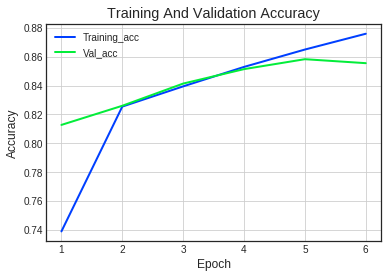

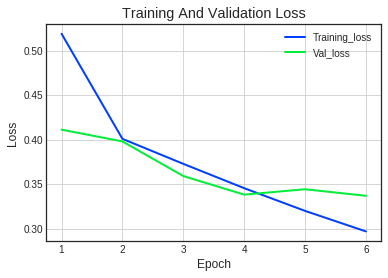

In [51]:
plt.style.use('seaborn-white')
plot_LearningCurve(history)


## Test model

---



---


In [38]:
loss, acc = model.evaluate(X_test, Y_oh_test)
print()
print("Test accuracy = ", acc)

10000/10000 [==============================] - 35s 3ms/step

Test accuracy =  0.8541


Confusion Matrix
[[4398  563]
 [ 896 4143]]


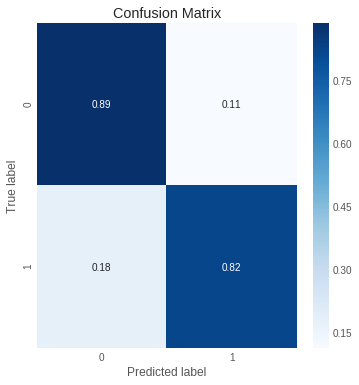

In [43]:
X_test_indices =X_test
pred_test=np.argmax(model.predict(X_test_indices),axis=1)
print('Confusion Matrix')
con_mat=confusion_matrix(Y_test,pred_test)
print(con_mat)
con_mat_df=pd.DataFrame(con_mat)
con_mat_df=con_mat_df/con_mat_df.sum(axis=1)
plt.style.use('ggplot')
import seaborn
figure=plt.figure(figsize=(5,5))
seaborn.heatmap(con_mat_df,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix")
plt.show()


In [0]:
def predict_reviews(sent):
  sent=np.array([sent])
  x=tokenizer.texts_to_sequences(sent)
  x = pad_sequences(x, padding='post', maxlen=maxlen)
  pred_x=np.argmax(model.predict(x),axis=1)
  print(" ")
  if pred_x==0:
    plt.figure(figsize=(5,5))
    img=plt.imread('/content/drive/My Drive/movie review/thumbs down.jpg')
    plt.title('Negative Review')
    plt.axis('off')
    plt.imshow(img)
  else:
    plt.figure(figsize=(5,5))
    img=plt.imread('/content/drive/My Drive/movie review/thumbsup.jpg')
    plt.title('Positive Review')
    plt.axis('off')
    plt.imshow(img)



## Predict the movie reviews:

---



---



Enter Review: Avengers: Endgame is one of the most ambitious, entertaining, emotional, and stunning blockbusters we’ve ever seen, and the best film in the Marvel Cinematic Universe canon thus far.
 


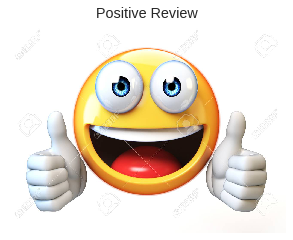

In [74]:
text=input('Enter Review: ')
predict_reviews(text)


Enter Review: The title says it all.....no but seriously this movie is awful. Bad acting, terrible writing, has a couple okay scenes, poor filming and very predictable plot. Seriously 2017 give me some more bad straight DVD movies that I can criticize and crack jokes on, not terrible garbage that isn't anything special like this...
 


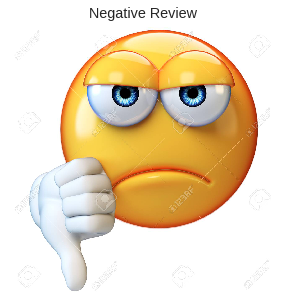

In [75]:
text=input('Enter Review: ')
predict_reviews(text)